# Import em1d

In [3]:
# Add zpic library to path
import sys
sys.path.append("../../lib")

import em1d as zpic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation, FFMpegWriter
import os

## Define the quantities

When initializing a particle species, we may specify a thermal generalized velocity, $\vec{u}_{th}$ such that the code will initialize the initial generalized velocity of simulation particles according to the following distribution:

$$
n\left( \vec{u} \right) \propto e^{ -\frac{1}{2} \left( \frac{u_x^2}{u_{thx}^2} + \frac{u_y^2}{u_{thy}^2} + \frac{u_y^2}{u_{thy}^2} \right) }
$$

Since we will be injected a limited number of particles in each simulation cell this procedure will cause a non-zero net momentum to be initialized. To avoid this, and to avoid initializing spurious oscillations, we do an additional step. For every simulation cell, we calculate the average momentum of the particles in that cell, and subtract this value from the particule generalized velocity. Note this does not affect the width of the distribution inside each cell, but rather shifts it to make sure it is centered about 0.

In [2]:
nx = 128   # Number of cells in the x direction
box = 12.8 # Size of each box
dt = 0.05  # Time step between each iteration 
ppc = 1000 # Particles per cell (number of particles in each cell)

uth = [1.00,0.0,0.0] # Constant thermal velocity

electrons = zpic.Species( "electrons", -1.0, ppc, uth = uth )
sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

# Plot the velocity distribution

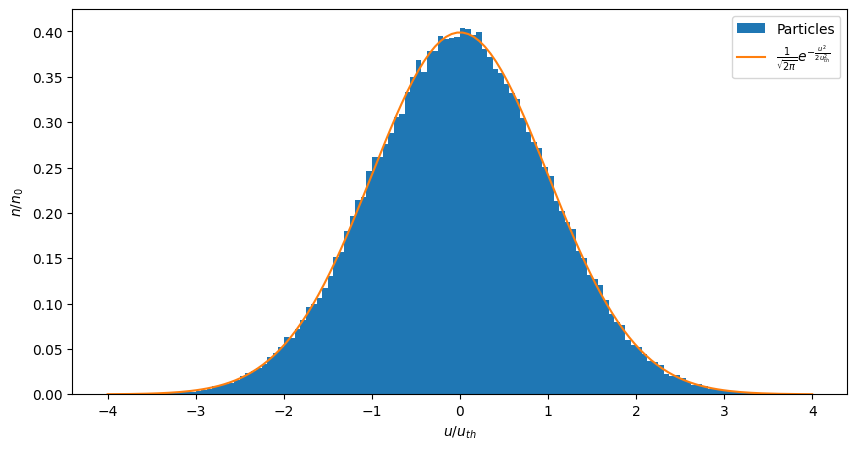

In [3]:
umax = 4 # Maximum velocity
nbins = 128 # Number of bins for the Histogram

plt.figure(figsize=(10,5))

urange = np.linspace(-umax, umax, num = nbins)
plt.hist( electrons.particles['ux'], bins = nbins, range = (-umax, umax), density = True, label ='Particles' )
plt.plot( urange, np.exp(- 0.5 * urange**2 / uth[0]**2)/np.sqrt(2*np.pi), label = r'$\frac{1}{\sqrt{2 \pi}}e^{-\frac{u^2}{2 u_{th}^2}}$' )

plt.xlabel("$ u / u_{th} $")
plt.ylabel("$ n / n_0 $")

plt.legend()
plt.show()

# Set the custom density profile and the external  Electric field

k = 0.37699111843077515


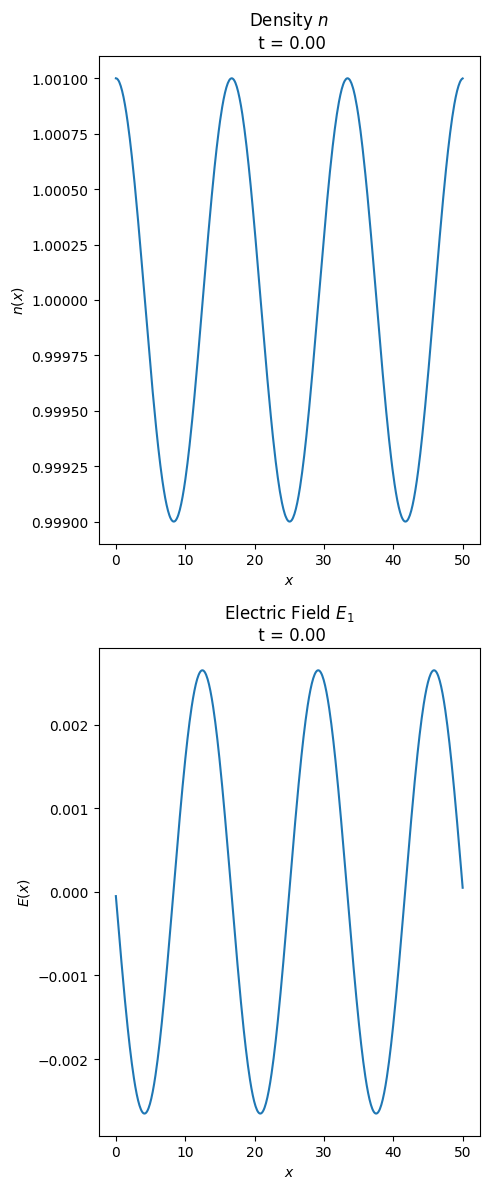

In [4]:
#nx = 100   # Number of cells in the x direction
#box = 10   # Size of the box
#dx = box / nx

box = 50
nx = 500
dx = box / nx

dt = 0.05  # Time step between each iteration 
ppc = 1000 # Particles per cell


# Initialize the velocities before the simulation
uth = [0.0,0.0,0.0] # Initial thermal velocity
ufl = [0.0,0.0,0.0] # Initial fluid velocity

# Dispersion relation
k = 3 * 2*np.pi/box  # box = 5 * lambda
print(f'k = {k}')
omega_p = 1

def omega(x):
    return np.sqrt(1 + (3/2*x**2*uth[0]**2)/omega_p**2)


# Density profile
n0 = 1
n1 = 0.001
def custom_n(x):
    return n0 + n1*np.cos(k*x)

density = zpic.Density( type = "custom", custom = custom_n )


# Background plasma
electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=uth, ufl=ufl, bc_type="periodic")
sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )

electrons.n_sort = 0

# Magnetic field
B_ext = zpic.InitialField(B_type = 'none')

sim.emf.init_fld( B_ext )


#Electric field
def E1_field( ix, dx ):
    # Ex is located at the center of the cell
    x = (ix+0.5)*dx
    E1 = -n1/k
    return [E1*np.sin(k*x - omega(k)*sim.t),0,0]

E_ext = zpic.InitialField(E_type = 'custom', E_custom = E1_field )

sim.emf.init_fld( E_ext )


# Plot the initial field values at the center of the cells
xmin = 0
xmax = sim.box
x_values = np.linspace(xmin, xmax, num=sim.nx)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 12))

ax1.plot(x_values, np.abs(electrons.charge()))
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$n(x)$")
ax1.set_title(f"Density $n$\n t = {sim.t:.2f}")

ax2.plot(x_values, sim.emf.Ex)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$E(x)$")
ax2.set_title(f"Electric Field $E_1$\n t = {sim.t:.2f}")

plt.tight_layout()
plt.show()

# Fourier transform before advancing the time step

In [5]:
## Compute the wave number axis
#k_fft_values = 2 * np.pi * np.fft.fftfreq(nx, d=dx) # k = 2pi*n/L
#positive_ks = k_fft_values >= 0
#k_fft_values = k_fft_values[positive_ks]
#
## Compute the Fourier transform and filter for positive frequencies
#fft_n = np.abs(np.fft.fft(np.abs(electrons.charge()))) # Full FFT
#fft_n = fft_n[positive_ks]
#
## Plot the Fourier spectrum
#plt.plot(k_fft_values, fft_n)
#plt.axvline(x=k, color='red', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
#plt.axvline(x=k_fft_values[6], color='green', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[6]:.2f}$")
#plt.yscale('log')
#plt.xlabel("$k$")
#plt.ylabel("Amplitude")
#plt.title(f"Fourier Transform of the Density profile at {sim.t}")
#plt.legend()
#plt.show()
#
## Find peaks in the FFT spectrum
#from scipy.signal import find_peaks
#peak_indices, _ = find_peaks(fft_n)
#
## Get the k-values and intensities of the peaks
#peak_k_values = k_fft_values[peak_indices]
#peak_intensities = fft_n[peak_indices]
#
## Print the peak locations and their intensities
#print("Peaks:")
#for k_val, intensity in zip(peak_k_values, peak_intensities):
#    print(f"k = {k_val:.2f}, Intensity = {intensity:.2e}")

In [6]:
## Compute the Fourier transform and filter for positive frequencies
#fft_E = np.abs(np.fft.fft(sim.emf.Ex)) # Full FFT
#fft_E = fft_E[positive_ks]
#
## Plot the Fourier spectrum
#plt.plot(k_fft_values, fft_E)
#plt.axvline(x=k, color='red', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
#plt.axvline(x=k_fft_values[6], color='green', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[6]:.2f}$")
#plt.yscale('log')
#plt.xlabel("$k$")
#plt.ylabel("Amplitude")
#plt.title(f"Fourier Transform of the Electric Field at {sim.t}")
#plt.legend()
#plt.show()
#
## Find peaks in the FFT spectrum
#from scipy.signal import find_peaks
#peak_indices, _ = find_peaks(fft_E)
#
## Get the k-values and intensities of the peaks
#peak_k_values = k_fft_values[peak_indices]
#peak_intensities = fft_E[peak_indices]
#
## Print the peak locations and their intensities
#print("Peaks:")
#for k_val, intensity in zip(peak_k_values, peak_intensities):
#    print(f"k = {k_val:.2f}, Intensity = {intensity:.2e}")

# Update the velocities after the simulation and before advancing the time step

[( 0, 4.9950054e-04, 0., 0., 0.) ( 0, 1.4985019e-03, 0., 0., 0.)
 ( 0, 2.4975038e-03, 0., 0., 0.) ... (19, 9.9750221e-01, 0., 0., 0.)
 (19, 9.9850118e-01, 0., 0., 0.) (19, 9.9950022e-01, 0., 0., 0.)]

[( 0, 4.9950054e-04, 0.00053052, 0., 0.)
 ( 0, 1.4985019e-03, 0.00053052, 0., 0.)
 ( 0, 2.4975038e-03, 0.00053051, 0., 0.) ...
 (19, 9.9750221e-01, 0.00053051, 0., 0.)
 (19, 9.9850118e-01, 0.00053052, 0., 0.)
 (19, 9.9950022e-01, 0.00053052, 0., 0.)]


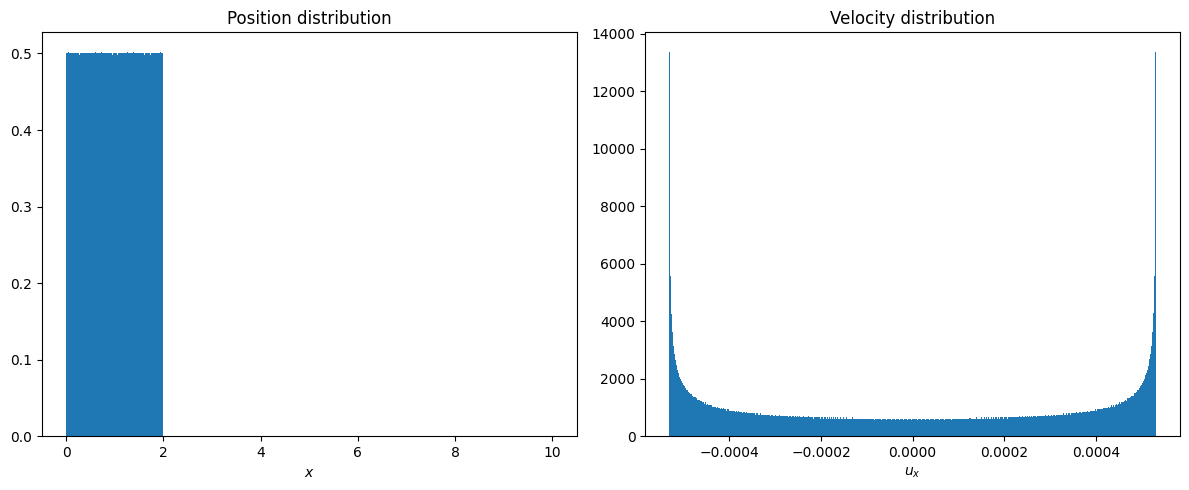

In [7]:
def v1(x):
    return omega(k)/k * n1 * np.cos(k*x)

print(electrons.particles)

for particle in electrons.particles:
    pos = (particle['ix'] + particle['x']) * sim.dx
    particle['ux'] = v1(pos)


print()
print(electrons.particles)

# Plot the density profile

urange = np.linspace(-2, 2, num = nx)

x_values = np.linspace(0, box, num = sim.nx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist( (electrons.particles['ix'] + electrons.particles['x']) * dx, bins = nx, range = (0, box), density = True)
ax1.set_xlabel(r"$x$")
ax1.set_title("Position distribution")

ax2.hist( electrons.particles['ux'], bins = nx, range = (-omega(k)/k*n1, omega(k)/k*n1), density = True)
#ax2.plot( urange, np.sqrt(1/(2*np.pi*uth[0]**2)) * np.exp(-1/(2*uth[0]**2)*(urange-ufl[0])**2), label = r'Maxwellian', linewidth = 2, color='red' )
ax2.set_xlabel(r"$u_x$")
ax2.set_title("Velocity distribution")
#ax2.legend()

plt.tight_layout()
plt.show()

#print(dir(electrons))
#help(electrons.add)
#print(dir(sim.species))

# Run the simulation and check how n and E evolve


Running simulation up to t = 3000 ...
n = 59999, t = 2999.95
Done.


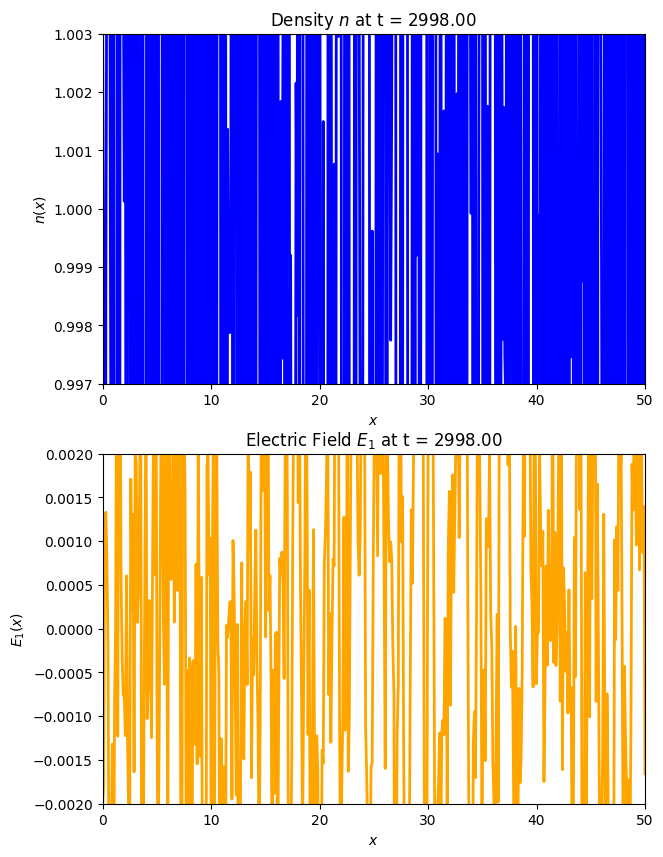

In [8]:
# Run the simulation

''' We run the simulation up to a fixed number of iterations, controlled by the variable `niter`,
storing the values of n and E at every timestep so we can analyze them later. '''
niter = 2000*10*3
Ex_t = np.zeros((niter,sim.nx))
n_t = np.zeros((niter,sim.nx))

print("\nRunning simulation up to t = {:g} ...".format(niter * sim.dt))
while sim.n < niter:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    Ex_t[sim.n,:] = sim.emf.Ex
    n_t[sim.n,:] =  np.abs(electrons.charge())
    sim.iter()

print("\nDone.")

# Movie parameters
nframes = 1000*1.5
fps = 16

# Increase the embed limit if the movie is large
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 128

# Create plots
x_vals = np.linspace(0, sim.box, sim.nx)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 10))
ax1.set_xlim((0, sim.box))
ax1.set_ylim((0.997, 1.003))
ax2.set_xlim((0, sim.box))
ax2.set_ylim((-0.002, 0.002))


line1, = ax1.plot([], [], lw=2, color='blue')
line2, = ax2.plot([], [], lw=2, color='orange')

ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$n(x)$")

ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$E_1(x)$")

# Animation function
def animate(i):
    time_index = int(i * len(Ex_t) / nframes)  # Map frame to time index in Ex_t and n_t
    line1.set_data(x_vals, n_t[time_index, :])
    line2.set_data(x_vals, Ex_t[time_index, :])
    ax1.set_title(f"Density $n$ at t = {time_index * sim.dt:.2f}")
    ax2.set_title(f"Electric Field $E_1$ at t = {time_index * sim.dt:.2f}")
    return (line1, line2)

# Create the movie
#anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False, blit=True, interval=1000.0 / fps)

output_folder = "simulation_videos"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist
output_path = os.path.join(output_folder, "simulation.mp4")

# Save the animation
writer = FFMpegWriter(fps=fps, metadata={"title": "Simulation", "artist": "YourName"})
with writer.saving(fig, output_path, dpi=100):
    for i in range(int(nframes)):
        animate(i)  # Update frame
        writer.grab_frame()


# Show the completed movie
#plt.close()
#HTML(anim.to_html5_video())

In [9]:
print(np.max(sim.emf.Bx))
print(np.max(sim.emf.By))
print(np.max(sim.emf.Bz))

0.0
0.0
0.0


# Fourier Transform at the end of the simulation

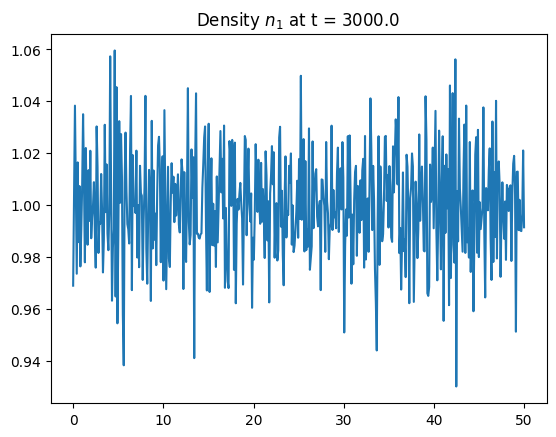

In [10]:
x = np.linspace(0, box , nx)
plt.plot(x, np.abs(electrons.charge()))
plt.title(f"Density $n_1$ at t = {sim.t}")
plt.show()

## Compute the Fourier transform and filter for positive frequencies
#fft_n = np.abs(np.fft.fft(np.abs(electrons.charge()))) # Full FFT
#fft_n = fft_n[positive_ks]
#
#
## Plot the Fourier spectrum
#plt.plot(k_fft_values, fft_n)
#plt.axvline(x=k, color='red', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
#plt.axvline(x=k_fft_values[6], color='green', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[6]:.2f}$")
#plt.axvline(x=k_fft_values[9], color='orange', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[9]:.2f}$")
#plt.axvline(x=k_fft_values[12], color='purple', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[12]:.2f}$")
#plt.yscale('log')
#plt.xlabel("$k$")
#plt.ylabel("Amplitude")
#plt.title(f"Fourier Transform of the Density profile at t = {sim.t}")
#plt.legend()
#plt.show()
#
#
## Find peaks in the FFT spectrum
#from scipy.signal import find_peaks
#peak_indices, _ = find_peaks(fft_n)
#
## Get the k-values and intensities of the peaks
#peak_k_values = k_fft_values[peak_indices]
#peak_intensities = fft_n[peak_indices]
#
## Print the peak locations and their intensities
#print("Peaks:")
#for k_val, intensity in zip(peak_k_values, peak_intensities):
#    print(f"k = {k_val:.2f}, Intensity = {intensity:.2e}")

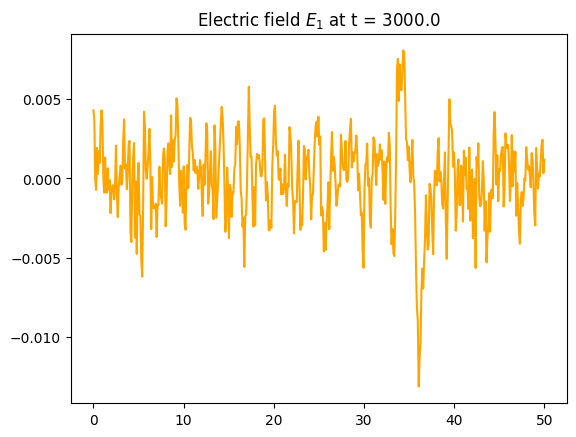

In [11]:
x = np.linspace(0, box , nx)
plt.plot(x, sim.emf.Ex, color='orange')
plt.title(f"Electric field $E_1$ at t = {sim.t}")
plt.show()

## Compute the Fourier transform and filter for positive frequencies
#fft_E = np.abs(np.fft.fft(sim.emf.Ex)) # Full FFT
#fft_E = fft_E[positive_ks]
#
#
## Plot the Fourier spectrum
#plt.plot(k_fft_values, fft_E)
#plt.axvline(x=k, color='red', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
#plt.axvline(x=k_fft_values[6], color='green', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[6]:.2f}$")
#plt.axvline(x=k_fft_values[9], color='orange', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[9]:.2f}$")
#plt.axvline(x=k_fft_values[12], color='purple', linestyle='--', linewidth = 1, label=f"$k = {k_fft_values[12]:.2f}$")
#plt.yscale('log')
#plt.xlabel("$k$")
#plt.ylabel("Amplitude")
#plt.title(f"Fourier Transform of the Electric field at t = {sim.t}")
#plt.legend()
#plt.show()
#
#
## Find peaks in the FFT spectrum
#from scipy.signal import find_peaks
#peak_indices, _ = find_peaks(fft_E)
#
## Get the k-values and intensities of the peaks
#peak_k_values = k_fft_values[peak_indices]
#peak_intensities = fft_E[peak_indices]
#
## Print the peak locations and their intensities
#print("Peaks:")
#for k_val, intensity in zip(peak_k_values, peak_intensities):
#    print(f"k = {k_val:.2f}, Intensity = {intensity:.2e}")

In [12]:
#fft_n = np.fft.fftshift(np.fft.fft(n_t, axis=1), axes=1)
#fft_Ex = np.fft.fftshift(np.fft.fft(Ex_t, axis=1), axes=1)
#freq_k = np.fft.fftshift(np.fft.fftfreq(nx, dx)) * 2 * np.pi
#
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
#
## Plot for the Density n_1
#im1 = axes[0].imshow(np.abs(fft_n), 
#                     aspect='auto', 
#                     extent=[freq_k[0], freq_k[-1], 0, sim.t], 
#                     interpolation="none",
#                     cmap='hot',
#                     origin='lower')
#axes[0].axvline(x=3*2*np.pi/box, color='r', linestyle='--', label='$k_1$')
#axes[0].axvline(x=6*2*np.pi/box, color='g', linestyle='--', label='$k_2$')
#axes[0].set_xlim(0, 30)
#axes[0].set_title('$t$ vs $k$ for the Density $n_1$')
#axes[0].set_xlabel("$k$ [$\omega_p/c$]")
#axes[0].set_ylabel("$t$ [$\omega_p^{-1}$]")
#axes[0].legend()
#fig.colorbar(im1, ax=axes[0], label='$|n_1(k)|$')
#
## Plot for the Electric field E_1
#im2 = axes[1].imshow(np.abs(fft_Ex), 
#                     aspect='auto', 
#                     extent=[freq_k[0], freq_k[-1], 0, sim.t], 
#                     interpolation="none",
#                     cmap='hot',
#                     origin='lower')
#axes[1].axvline(x=3*2*np.pi/box, color='r', linestyle='--', label='$k_0$')
#axes[1].axvline(x=6*2*np.pi/box, color='g', linestyle='--', label='$k_1$')
#axes[1].set_xlim(0, 30)
#axes[1].set_title('$t$ vs $k$ for the Electric field $E_1$')
#axes[1].set_xlabel("$k$ [$\omega_p/c$]")
#axes[1].set_ylabel("$t$ [$\omega_p^{-1}$]")
#axes[1].legend()
#fig.colorbar(im2, ax=axes[1], label='$|E_1(k)|$')
#
#plt.tight_layout()
#plt.show()
#

# Define a function that measures the stability time of the simulation

In [5]:
def measure_stability_time_n(sim, k_target=k, tolerance=0.3, max_iter=20000, relative_threshold=0.10, show = False):
    """
    Measures the time before a new peak appears in the Fourier spectrum, signaling instability.

    Parameters:
        sim (Simulation): The ZPIC simulation object.
        k_target (float): Target wave number (k) to monitor.
        tolerance (float): Range around k_target to identify the primary mode.
        max_iter (int): Maximum number of iterations to run the simulation.
        relative_threshold (float): Fraction of the intensity of k_target for detecting a new peak.

    Returns:
        float: Stability time in simulation units.
    """
    nx = sim.nx
    dx = sim.box / nx
    k_fft_values = 2 * np.pi * np.fft.fftfreq(nx, d=dx)
    # k_fft = [0,0.63,1.26,1.88,2.51,…]

    # Find indices corresponding to the target k range
    target_indices = (k_fft_values >= (k_target - tolerance)) & (k_fft_values <= (k_target + tolerance))

    # Exclude the k=0 mode from analysis
    non_zero_indices = k_fft_values > 0  # Exclude k=0 
    relevant_indices = non_zero_indices & ~target_indices  # Indices outside k_target and excluding k=0

    ###########

    fft = np.abs(np.fft.fft(np.abs(electrons.charge())))
    dominant_target_amplitude = np.max(fft[target_indices])
    new_peak_amplitude = np.max(fft[relevant_indices])

    #plt.plot(k_fft_values, fft, color = 'purple')
    #plt.axvline(x=k_fft_values[3], color='green', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
    #plt.yscale('log')
    #plt.xlim(0, 30)
    #plt.show()
    #print(f"Peak 0 intensity = {dominant_target_amplitude}")
    #print(f"Peak 1 intensity = {new_peak_amplitude}")


    ###########

    for _ in range(max_iter):
        sim.iter()  # Advance one time step # A CADA OMEGA_P (2PI) # Usar run talvez

        # Compute fft of density
        fft = np.abs(np.fft.fft(np.abs(electrons.charge())))

        # Extract amplitude at k_target
        dominant_target_amplitude = np.max(fft[target_indices])

        # Search for new peaks outside k_target range (and exclude k=0)
        new_peak_amplitude = np.max(fft[relevant_indices])  # Max intensity excluding k=0 and k_target

        # Check if new peak is significant compared to k_target
        if new_peak_amplitude > relative_threshold * dominant_target_amplitude:
            if show == True:
                plt.plot(k_fft_values, fft, color = 'red')
                plt.axvline(x=k_fft_values[3], color='green', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
                plt.yscale('log')
                plt.xlim(0, 30)
                plt.show()

                print(f"Peak 0 intensity = {dominant_target_amplitude}")
                print(f"Peak 1 intensity = {new_peak_amplitude}")

            return sim.t  # Return stability time when interference is detected

    if show == True:
        plt.plot(k_fft_values, fft, color = 'blue')
        plt.axvline(x=k_fft_values[3], color='green', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
        plt.yscale('log')
        plt.xlim(0, 30)
        plt.show()
    
        print(f"Peak 0 intensity = {dominant_target_amplitude}")
        print(f"Peak 1 intensity = {new_peak_amplitude}")
    
    return sim.t  # If no new peaks, return max simulation time

In [14]:
def measure_stability_time_E(sim, k_target=k, tolerance=0.3, max_iter=20000, relative_threshold=0.1, show = False):
    """
    Measures the time before a new peak appears in the Fourier spectrum, signaling instability.

    Parameters:
        sim (Simulation): The ZPIC simulation object.
        k_target (float): Target wave number (k) to monitor.
        tolerance (float): Range around k_target to identify the primary mode.
        max_iter (int): Maximum number of iterations to run the simulation.
        relative_threshold (float): Fraction of the intensity of k_target for detecting a new peak.

    Returns:
        float: Stability time in simulation units.
    """
    nx = sim.nx
    dx = sim.box / nx
    k_fft_values = 2 * np.pi * np.fft.fftfreq(nx, d=dx)
    # k_fft = [0,0.63,1.26,1.88,2.51,…]

    # Find indices corresponding to the target k range
    target_indices = (k_fft_values >= (k_target - tolerance)) & (k_fft_values <= (k_target + tolerance))

    # Exclude the k=0 mode from analysis
    non_zero_indices = k_fft_values > 0  # Exclude k=0
    relevant_indices = non_zero_indices & ~target_indices  # Indices outside k_target and excluding k=0

    for _ in range(max_iter):
        sim.iter()  # Advance one time step

        # Compute fft of Ex
        fft = np.abs(np.fft.fft(sim.emf.Ex))

        # Extract amplitude at k_target
        dominant_target_amplitude = np.max(fft[target_indices])

        # Search for new peaks outside k_target range (and exclude k=0)
        new_peak_amplitude = np.max(fft[relevant_indices])  # Max intensity excluding k=0 and k_target

        # Check if new peak is significant compared to k_target
        if new_peak_amplitude > relative_threshold * dominant_target_amplitude:
            if show == True:
                plt.plot(k_fft_values, fft, color = 'red')
                plt.axvline(x=k_fft_values[3], color='green', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
                plt.yscale('log')
                plt.xlim(0, 30)
                plt.show()

                print(f"Peak 0 intensity = {dominant_target_amplitude}")
                print(f"Peak 1 intensity = {new_peak_amplitude}")

            return sim.t  # Return stability time when interference is detected

    if show == True:
        plt.plot(k_fft_values, fft, color = 'blue')
        plt.axvline(x=k_fft_values[3], color='green', linestyle='--', linewidth = 1, label=f"$k = {k:.2f}$")
        plt.yscale('log')
        plt.xlim(0, 30)
        plt.show()
    
        print(f"Peak 0 intensity = {dominant_target_amplitude}")
        print(f"Peak 1 intensity = {new_peak_amplitude}")

    return sim.t  # If no new peaks, return max simulation time

# $t_{max}$ vs $dt$

In [15]:
#dt_courant = 1 / np.sqrt(1.0/dx**2)
#print(dt_courant)
#
#dt_values = np.linspace(0.03, 0.99*dt_courant, 10)  # Range of time steps to test
#print(dt_values)
#stability_times = []
#
#for dt_test in dt_values:
#    nx = 100
#    box = 10
#    ppc = 1000
#    k = 3 * 2*np.pi/box
#    n1 = 0.001
#    # Create a new simulation with the current time step
#    density = zpic.Density( type = "custom", custom = lambda x: (n0 + n1*np.cos(k*x)) )
#    electrons = zpic.Species("electrons", -1.0, ppc, density=density, uth=[0,0,0], ufl=[0,0,0], bc_type="periodic")
#    sim = zpic.Simulation( nx = nx, box = box, dt = dt_test, species = electrons )
#    for particle in electrons.particles:
#        pos = (particle['ix'] + particle['x']) * sim.dx
#        particle['ux'] = v1(pos)
#    stability_time = measure_stability_time_n(sim)
#    #stability_time = measure_stability_time_E(sim)
#    stability_times.append(stability_time)
#
#
## Convert results to arrays for plotting
#dt_values = np.array(dt_values)
#stability_times = np.array(stability_times)
#
#plt.plot(dt_values, stability_times, marker='o')
#plt.xlabel(r"$dt$")
#plt.ylim((240, 250))
#plt.ylabel(r"$t_{max}$")
#plt.title("Stability Time vs. Time Step")
#plt.show()

# $t_{max}$ vs ppc

In [16]:
#ppc_values = np.linspace(100, 1000, 10, dtype=int)  # Range of ppc to test
#print(ppc_values)
#stability_times = []
#
#for ppc_test in ppc_values:
#    nx = 100
#    box = 10
#    dt = 0.05
#    k = 3 * 2*np.pi/box
#    n1 = 0.001
#    # Create a new simulation with the current ppc
#    density = zpic.Density( type = "custom", custom = lambda x: (n0 + n1*np.cos(k*x)) )
#    electrons = zpic.Species("electrons", -1.0, ppc=ppc_test, density=density, uth=[0,0,0], ufl=[0,0,0], bc_type="periodic")
#    sim = zpic.Simulation( nx = nx, box = box, dt = dt, species = electrons )
#    for particle in electrons.particles:
#        pos = (particle['ix'] + particle['x']) * sim.dx
#        particle['ux'] = v1(pos)
#    stability_time = measure_stability_time_n(sim)
#    #stability_time = measure_stability_time_E(sim)
#    stability_times.append(stability_time)
#
## Convert results to arrays for plotting
#ppc_values = np.array(ppc_values)
#stability_times = np.array(stability_times)
#
#plt.plot(ppc_values, stability_times, marker='o')
#plt.xlabel(r"$ppc$")
#plt.ylabel(r"$t_{max}$")
#plt.yscale('log')
#plt.title("Stability Time vs. Particles per cell")
#plt.show()

# $t_{max}$ vs nx

[ 20.  40.  60.  80. 100. 120. 140. 160. 180. 200.]
20.0
40.0
60.0
80.0
100.0
120.0
140.0
160.0
180.0
200.0
[0.25       0.125      0.08333334 0.0625     0.05       0.04166667
 0.03571429 0.03125    0.02777778 0.025     ]


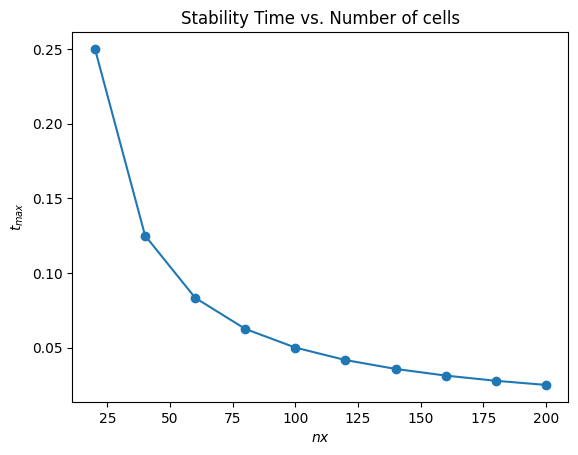

In [8]:
#nx_values = np.linspace(20, 200, 10)  # Range of nx to test
#print(nx_values)
#stability_times = []
#
#for nx_test in nx_values:
#    print(nx_test)
#    box = 10
#    dt = 0.05
#    ppc = 1000
#    k = 3 * 2*np.pi/box
#    n1 = 0.001
#    # Create a new simulation with the current nx
#    if dt < box/nx_test: # Courant condition : dt < dx
#        density = zpic.Density( type = "custom", custom = lambda x: (n0 + n1*np.cos(k*x)) )
#        electrons = zpic.Species("electrons", -1.0, ppc = ppc, density=density, uth=[0,0,0], ufl=[0,0,0], bc_type="periodic")
#        sim = zpic.Simulation( nx = nx_test, box = box, dt = dt, species = electrons )
#        for particle in electrons.particles:
#            pos = (particle['ix'] + particle['x']) * sim.dx
#            particle['ux'] = v1(pos)
#        stability_time = measure_stability_time_n(sim)
#        #stability_time = measure_stability_time_E(sim)
#        stability_times.append(stability_time)
#
## Convert results to arrays for plotting
#nx_values = np.array(nx_values[dt < box/nx_values])
#stability_times = np.array(stability_times)
#print(stability_times)
#
#plt.plot(nx_values, stability_times, marker='o')
#plt.xlabel(r"$nx$")
#plt.ylabel(r"$t_{max}$")
#plt.title("Stability Time vs. Number of cells")
#plt.show()

nx_values = np.linspace(20, 200, 10)  # Range of nx to test
print(nx_values)
stability_times = []

for nx_test in nx_values:
    print(nx_test)
    box = 10
    dt = 5/nx_test
    ppc = 1000
    k = 3 * 2*np.pi/box
    n1 = 0.001
    # Create a new simulation with the current nx
    if dt < box/nx_test: # Courant condition : dt < dx
        density = zpic.Density( type = "custom", custom = lambda x: (n0 + n1*np.cos(k*x)) )
        electrons = zpic.Species("electrons", -1.0, ppc = ppc, density=density, uth=[0,0,0], ufl=[0,0,0], bc_type="periodic")
        sim = zpic.Simulation( nx = nx_test, box = box, dt = dt, species = electrons )
        for particle in electrons.particles:
            pos = (particle['ix'] + particle['x']) * sim.dx
            particle['ux'] = v1(pos)
        stability_time = measure_stability_time_n(sim)
        #stability_time = measure_stability_time_E(sim)
        stability_times.append(stability_time)

# Convert results to arrays for plotting
nx_values = np.array(nx_values[dt < box/nx_values])
stability_times = np.array(stability_times)
print(stability_times)

plt.plot(nx_values, stability_times, marker='o')
plt.xlabel(r"$nx$")
plt.ylabel(r"$t_{max}$")
plt.title("Stability Time vs. Number of cells")
plt.show()



# $t_{max}$ vs $n_1$

In [18]:
#def v1_n1(x, n1):
#    return omega(k)/k * n1 * np.cos(k*x)
#
#n1_values = np.linspace(0.0001, 0.01, 10)  # Range of n1 to test
#print(n1_values)
#stability_times = []
#
#for n1_test in n1_values:
#    nx = 100
#    box = 10
#    dt = 0.05
#    ppc = 1000
#    k = 3 * 2*np.pi/box
#    # Create a new simulation with the current n1
#    density = zpic.Density( type = "custom", custom = lambda x: (n0 + n1_test*np.cos(k*x)) )
#    electrons = zpic.Species("electrons", -1.0, ppc = ppc, density=density, uth=[0,0,0], ufl=[0,0,0], bc_type="periodic")
#    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )
#    for particle in electrons.particles:
#        pos = (particle['ix'] + particle['x']) * sim.dx
#        particle['ux'] = v1_n1(pos, n1_test)
#    #stability_time = measure_stability_time_n(sim)
#    stability_time = measure_stability_time_E(sim)
#    stability_times.append(stability_time)
#
## Convert results to arrays for plotting
#n1_values = np.array(n1_values)
#stability_times = np.array(stability_times)
#
#plt.plot(n1_values, stability_times, marker='o')
#plt.xlabel(r"$n_1$")
#plt.ylabel(r"$t_{max}$")
#plt.yscale('log')
#plt.title("Stability Time vs. Density perturbation amplitude")
#plt.show()

# $t_{max}$ vs $k$

In [19]:
#def v1_k(x, k):
#    return omega(k)/k * n1 * np.cos(k*x)
#
#k_values = [1*2*np.pi/box, 2*2*np.pi/box, 3*2*np.pi/box, 4*2*np.pi/box, 5*2*np.pi/box, 6*2*np.pi/box, 6*2*np.pi/box, 7*2*np.pi/box,
#            8*2*np.pi/box, 9*2*np.pi/box, 10*2*np.pi/box]  # Range of k to test
#stability_times = []
#
#for k_test in k_values:
#    nx = 100
#    box = 10
#    dt = 0.05
#    ppc = 1000
#    n1 = 0.001
#    # Create a new simulation with the current k
#    density = zpic.Density( type = "custom", custom = lambda x: (n0 + n1*np.cos(k_test*x)) )
#    electrons = zpic.Species("electrons", -1.0, ppc = ppc, density=density, uth=[0,0,0], ufl=[0,0,0], bc_type="periodic")
#    sim = zpic.Simulation( nx, box = box, dt = dt, species = electrons )
#    for particle in electrons.particles:
#        pos = (particle['ix'] + particle['x']) * sim.dx
#        particle['ux'] = v1_k(pos, k_test)
#    #stability_time = measure_stability_time_n(sim, k_target=k_test)
#    stability_time = measure_stability_time_E(sim)
#    stability_times.append(stability_time)
#
## Convert results to arrays for plotting
#k0_values = np.array(k_values)
#stability_times = np.array(stability_times)
#
#plt.plot(k0_values, stability_times, marker='o')
#plt.xlabel(r"$k_0$")
#plt.ylabel(r"$t_{max}$")
#plt.title("Stability Time vs. Wave number")
#plt.show()